In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
from tensorflow.keras.models import load_model
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa
from datetime import datetime
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from pesq import pesq
import pystoi
import pandas as pd
import tensorflow.keras.backend as K
from utils import calculate_snr, itakura_distortion, somar_sinais, add_white_gaussian_noise, performance
from evaluate import NoisyTargetEvaluator

from IPython import display
from sound import Sound

In [3]:
base_shape_size = 8192
ws = 255
ol = 128

In [4]:
evaluator = NoisyTargetEvaluator(
                    base_shape_size,
                    '/tf/Dados/Vozes/',
                    '/tf/Dados/Ruido/',
                    '/tf/Etapa 3/UNet/res-unet-convlstm-loss-0.0087-epochs-64-2023-11-12_14-28-26.h5',
                    'Attention-Res-Unet'
            )

Loading Noise Files: 100%|██████████| 8137/8137 [00:07<00:00, 1069.36it/s]
/tf/utils/sound.py:65: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  clean_sounds = [sound for sound in clean_sounds if sound != self.TOO_SHORT_ERROR]
/tf/utils/sound.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_sounds = [sound for sound in noise_sounds if sound != self.TOO_SHORT_ERROR]


In [5]:
df_results = evaluator.evaluate(batch_num=4)

100%|██████████| 4/4 [00:37<00:00,  9.49s/it]


File saved to Attention-Res-Unet-ConvLSTM-metrics_2023-11-12_16-16-59.xlsx


In [17]:
# model = load_model('unet-STFT-20-epochs-2023-11-02_16-22-10.h5')
# model = load_model('res-unet-STFT-150-epochs-2023-11-02_22-50-19.h5')
model = load_model('../GAN/generator-pix2pix-40000-steps2023-11-06_15-35-42.h5')

In [18]:
def plot_signals(clean_signal, noisy_signal, filtered_signal):
    plt.figure(figsize=(10, 10))
    
    # Plote o sinal original
    plt.subplot(4, 1, 1)
    plt.plot(clean_signal, color='blue')
    plt.title('Sinal de Voz')
    plt.xlabel('Tempo (ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Plote o sinal original
    plt.subplot(4, 1, 2)
    plt.plot(noisy_signal, color='lightcoral')
    plt.title('Sinal de Voz')
    plt.xlabel('Tempo (ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Plote o sinal do LPC gerado
    plt.subplot(4, 1, 3)
    plt.plot(filtered_signal, color='red')
    plt.title('Sinal de Voz com Ruído')
    plt.xlabel('Tempo (ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

In [19]:
results = []

for _ in tqdm(range(batch_num)):
    x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_completo(batch_size=128))
    results.append((process_batch(x_batch, y_batch, model),metrics_batch_df))

df_resultado = pd.DataFrame()

for result , metrics_batch_df in results:
    pesq_scores, stoi_scores, snr_scores, ID_scores = result
    metrics_batch_df['PESQ (Filtered)'] = pesq_scores
    metrics_batch_df['STOI (Filtered)'] = stoi_scores
    metrics_batch_df['SNR (Filtered)'] = snr_scores
    metrics_batch_df['ID (Filtered)'] = ID_scores
    
    df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

100%|██████████| 50/50 [12:16<00:00, 14.74s/it]


In [20]:
df_resultado

,SNR Ruído aditivo,SNR Ruído Gauss Branco,PESQ,STOI,SNR,ID,PESQ (Filtered),STOI (Filtered),SNR (Filtered),ID (Filtered)
0,8,19.0,1.477838,0.690404,7.599400,-0.119787,2.823323,0.795644,13.082855,-0.636186
1,14,23.0,2.348331,0.954797,13.437200,-0.144846,4.186930,0.986063,21.087539,-0.112320
2,5,16.0,2.201138,0.525327,4.579012,-0.810011,3.658654,0.617936,10.423476,-0.315159
3,11,18.0,2.121264,0.786893,10.181873,0.101833,3.059282,0.868682,10.763741,-0.027783
4,12,16.0,2.125038,0.843521,10.467219,-0.121255,3.234008,0.890545,17.613435,-0.291896
...,...,...,...,...,...,...,...,...,...,...
6394,12,16.0,1.798871,0.825825,10.494804,-0.256095,3.021610,0.879560,7.390014,-0.469572
6395,5,22.0,1.990539,0.830086,4.882879,0.219700,3.435914,0.900934,18.763273,0.067415
6396,9,23.0,3.826706,0.968401,8.817333,-0.482856,3.770864,0.990839,15.420517,0.105914
6397,5,20.0,1.360054,0.624642,4.822689,-0.210572,2.633220,0.624891,6.937475,-0.301758


In [21]:
df_resultado.describe()

,SNR Ruído aditivo,SNR Ruído Gauss Branco,PESQ,STOI,SNR,ID,PESQ (Filtered),STOI (Filtered),SNR (Filtered),ID (Filtered)
count,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000
mean,9.578528,19.530083,1.911429,0.802864,8.687318,-0.030902,2.992651,0.868144,11.063372,-0.171800
std,5.756118,2.887652,0.458612,0.130683,4.995400,0.394801,0.544164,0.105915,3.759415,0.246491
min,0.000000,15.000000,1.031323,0.094910,-0.334987,-2.267362,1.087591,0.033928,-5.378182,-1.896314
25%,5.000000,17.000000,1.573735,0.728143,4.587697,-0.251432,2.643224,0.823741,8.197026,-0.313197
50%,10.000000,20.000000,1.838728,0.830834,8.875856,-0.013684,3.039688,0.897753,10.549164,-0.166765
75%,15.000000,22.000000,2.152014,0.902511,12.932902,0.213539,3.396662,0.943404,13.687566,-0.026759
max,19.000000,24.000000,4.307766,0.998302,17.882032,1.697754,4.279882,0.995313,24.000587,1.166071


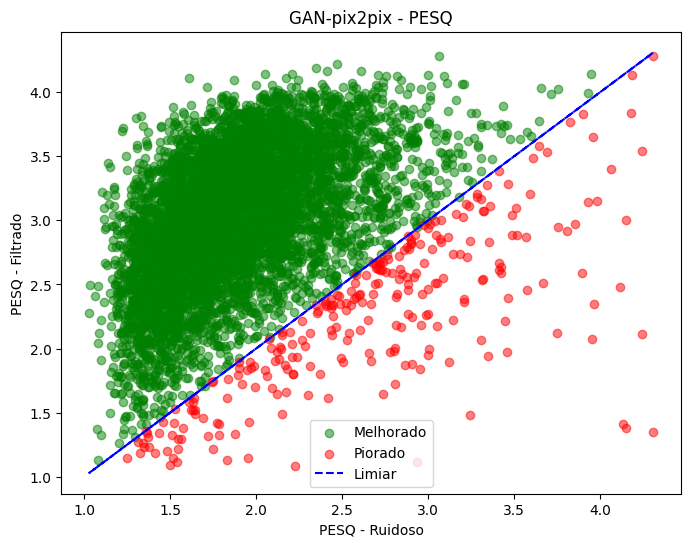

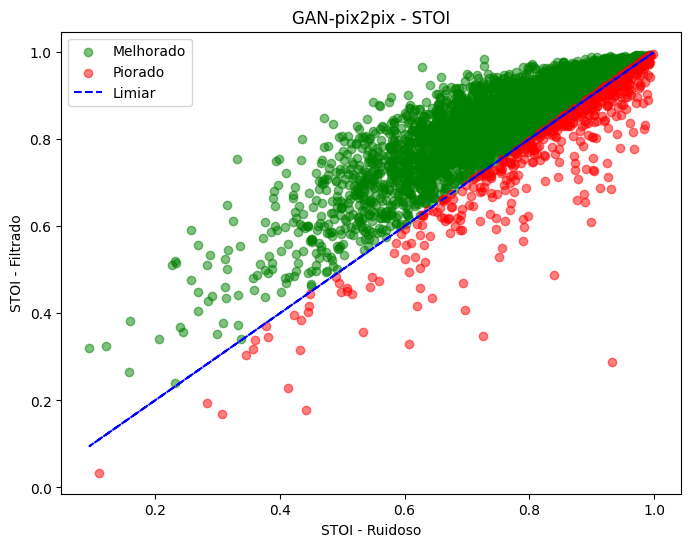

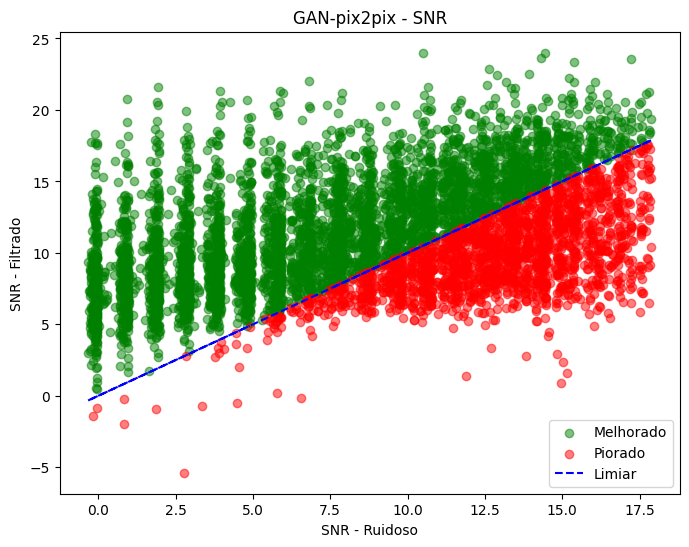

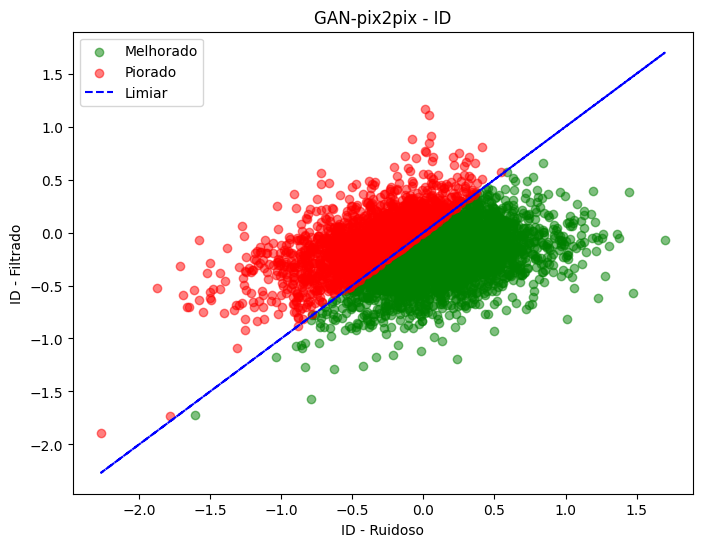

In [22]:
performance(df_resultado, 'GAN-pix2pix')

In [23]:
# Get the current datetime
current_datetime = datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Define the file name with the datetime
file_name = f"gan-pix2pix_{datetime_str}.xlsx"

In [24]:
df_resultado.to_excel(file_name, index=False)